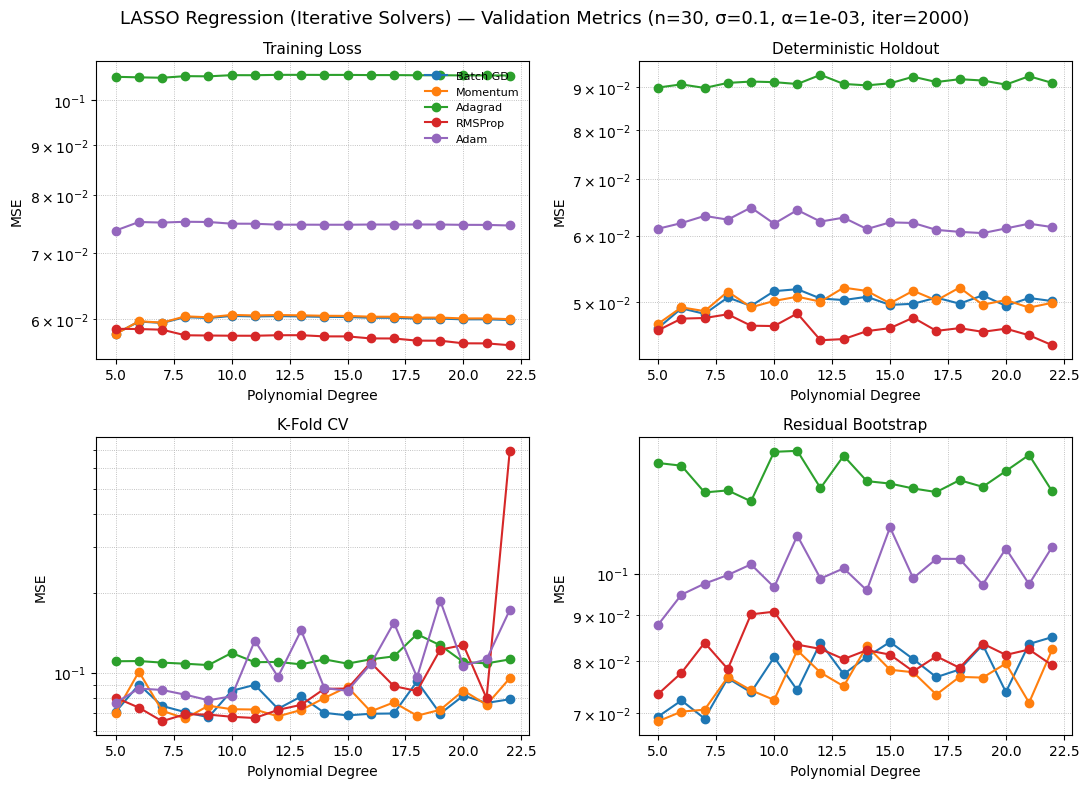

In [3]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt

from src.data import equispaced_points, runge_function
from src.basis import vandermonde
from src.gd import (
    batch_gradient_descent_lasso,
    momentum_gradient_descent_lasso,
    adam_solver_lasso,
    rmsprop_solver_lasso,
    adagrad_solver_lasso,
)
from src.validation import deterministic_holdout, kfold_cv, residual_bootstrap

np.random.seed(314)

# -------------------
# Config
# -------------------
degrees = np.arange(5, 23)
alpha = 1e-3  # LASSO penalty

x = equispaced_points(30)
y = runge_function(x) + np.random.normal(0, 0.1, size=30)

solvers = {
    "Batch GD": lambda X, y: batch_gradient_descent_lasso(X, y, alpha=alpha, eta=1e-3, max_iter=400),  # Match OLS
    "Momentum": lambda X, y: momentum_gradient_descent_lasso(X, y, alpha=alpha, eta=1e-3, beta=0.9, max_iter=400),
    "Adagrad": lambda X, y: adagrad_solver_lasso(X, y, alpha=alpha, lr=5e-3, max_iter=400),
    "RMSProp": lambda X, y: rmsprop_solver_lasso(X, y, alpha=alpha, lr=1e-3, max_iter=400),
    "Adam": lambda X, y: adam_solver_lasso(X, y, alpha=alpha, lr=1e-3, max_iter=400),
}
methods = ["Training Loss", "Deterministic Holdout", "K-Fold CV", "Residual Bootstrap"]
results = {m: {s: [] for s in solvers} for m in methods}

# -------------------
# Lightened sampling
# -------------------
HOLDOUT_B = 5
BOOTSTRAP_B = 5
K_FOLDS = 3

# -------------------
# Compute metrics
# -------------------
for d in degrees:
    X = vandermonde(x, d)
    for name, solver in solvers.items():
        coef, predict_fn, info = solver(X, y)
        y_pred = predict_fn(X, coef)
        train_loss = np.mean((y - y_pred) ** 2)
        
        results["Training Loss"][name].append(train_loss)
        results["Deterministic Holdout"][name].append(
            deterministic_holdout(x, y, runge_function, d, solver, B=HOLDOUT_B, sigma=0.1)
        )
        results["K-Fold CV"][name].append(kfold_cv(x, y, d, solver, K=K_FOLDS))
        results["Residual Bootstrap"][name].append(
            residual_bootstrap(x, y, d, solver, B=BOOTSTRAP_B)
        )

# -------------------
# Plot
# -------------------
fig, axes = plt.subplots(2, 2, figsize=(11, 8))
axes = axes.ravel()

colors = {
    "Batch GD": "C0",
    "Momentum": "C1",
    "Adagrad": "C2",
    "RMSProp": "C3",
    "Adam": "C4",
}

for i, method in enumerate(methods):
    ax = axes[i]
    for solver_name, color in colors.items():
        ax.plot(degrees, results[method][solver_name], "o-", label=solver_name, color=color, linewidth=1.5)
    ax.set_title(method, fontsize=11)
    ax.set_xlabel("Polynomial Degree")
    ax.set_ylabel("MSE")
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle=":", linewidth=0.6)
    if i == 0:
        ax.legend(frameon=False, fontsize=8)

fig.suptitle(f"LASSO Regression (Iterative Solvers) — Validation Metrics (n=30, σ=0.1, α={alpha:.0e}, iter=2000)",
             fontsize=13, y=0.98)
plt.tight_layout()

# -------------------
# Save
# -------------------
fig_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))
os.makedirs(fig_dir, exist_ok=True)
plt.savefig(os.path.join(fig_dir, 'lasso_gd_validation_metrics_2x2.pdf'), bbox_inches='tight')
plt.show()